In [1]:
#imports for problems 2 and 3
from PIL import Image, ImageOps
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters
from scipy import signal as sig
from scipy import ndimage as ndi
from skimage.io import imread
from skimage.feature import peak_local_max, corner_harris, corner_peaks

In [2]:
#Converts image into numpy array
def convertImage(picture):
    img = Image.open(picture)
    img = ImageOps.grayscale(img)
    return np.array(img)

In [3]:
#Creating gaussian matrix and calculating patial derivatives 
def gKernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    derivativex = (-x/sigma**2)*g 
    derivativey = (-y/sigma**2)*g 
    return g, derivativey, derivativex

In [4]:
#Vertical portion of kernel
def verticalKernel(image,kernel):
    count = len(kernel)//2
    
    newImage = np.zeros(image.shape)
    padding = np.zeros((1,image.shape[1]))
    
    holder = np.vstack((padding, image))
    holder = np.vstack((holder,padding))
    
    for zeros in np.arange(0,count-1,1):
        holder = np.vstack((padding, holder))
        holder = np.vstack((holder,padding))
        
    holder = holder.T
    
    for i in np.arange(0,image.shape[1],1):
        for j in np.arange(0,image.shape[0],1):
            temp = []
            for k in np.arange(0,len(kernel),1):
            #temp = np.array([holder[i][j], holder[i][j+1], holder[i][j+2]])
                temp.append(holder[i][j+k])
            temp = np.multiply(temp, kernel)
            
            value = np.sum(temp)
            newImage[j][i] = value
            
    return newImage


In [5]:
#Horizontal portion of kernel
def horizontalKernel(image,kernel):
    count = len(kernel)//2
    newImage = np.zeros(image.shape)
    padding = np.zeros((image.shape[0],1))
    holder = np.hstack((padding, image))
    holder = np.hstack((holder,padding))
    
    for zeros in np.arange(0,count-1,1):
        holder = np.hstack((padding, holder))
        holder = np.hstack((holder,padding))
        
    
    for i in np.arange(0,image.shape[0],1):
        for j in np.arange(0,image.shape[1],1):
            temp = []
            for k in np.arange(0,len(kernel),1):
            #temp = np.array([holder[i][j], holder[i][j+1], holder[i][j+2]])
                temp.append(holder[i][j+k])
            temp = np.multiply(temp, kernel)
            
            value = np.sum(temp)
            newImage[i][j] = value
           
    return newImage


In [6]:
#For problem 2, calculating non-max supression
#SOURCE: https://towardsdatascience.com/canny-edge-detection-step-by-step-in-python-computer-vision-b49c3a2d8123
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

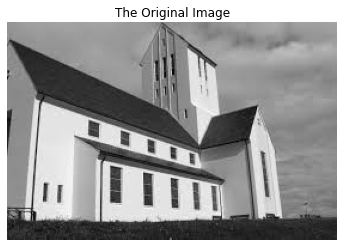

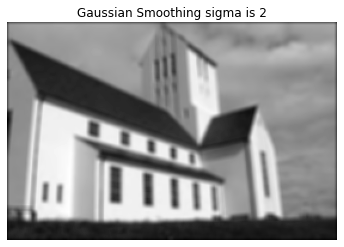

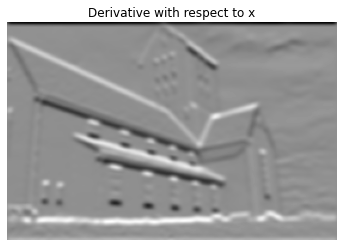

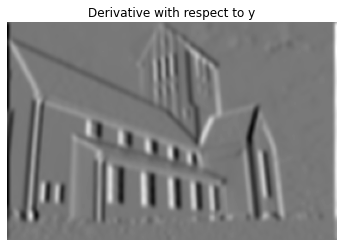

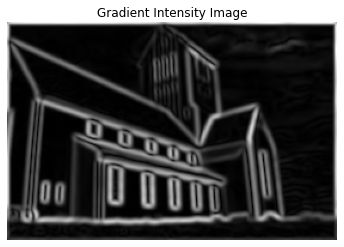

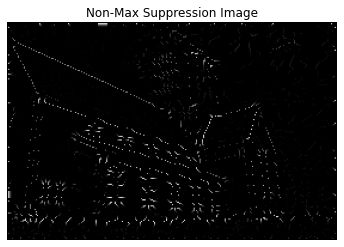

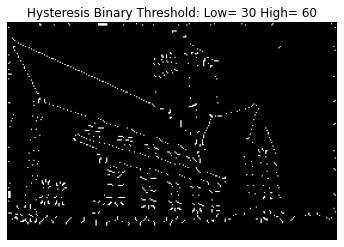

In [7]:
def edgeDetection(image, sigma, low, high):
    
    #1 - Get image, convert to array
    image = convertImage(image)
    plt.title('The Original Image')
    plt.axis('off')
    plt.imshow(image,cmap='gray')
    
    # Getting gaussian kernel and partial derivative
    kernel, derivativey, derivativex = gKernel(5,sigma)
    
    # Getting 6th row to use in convolution 
    x_y = kernel[4]
    
    # Two step convolution
    vertical_output = verticalKernel(image, x_y)
    final_output = horizontalKernel(vertical_output, x_y)
    plt.figure()
    plt.title('Gaussian Smoothing sigma is '+str(sigma))
    plt.axis('off')
    plt.imshow(final_output,cmap='gray')
    
    # Derivative with respect to x
    column_x = derivativex[:,0]
    row_x = derivativex[0]
    Ix = verticalKernel(final_output, column_x)
    Ix = horizontalKernel(Ix, row_x)
    plt.figure()
    plt.title('Derivative with respect to x')
    plt.axis('off')
    plt.imshow(Ix,cmap='gray')
    
    # Derivative with respect to y
    column_y = derivativey[:,0]
    row_y = derivativey[0]
    Iy = verticalKernel(final_output, column_y)
    Iy = horizontalKernel(Iy, row_y)
    plt.figure()
    plt.title('Derivative with respect to y')
    plt.axis('off')
    plt.imshow(Iy,cmap='gray')
    
    # Calculating direction magnitude
    G = np.hypot(Ix,Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    plt.figure()
    plt.title('Gradient Intensity Image')
    plt.axis('off')
    plt.imshow(G,cmap='gray')
    
    #Removing non local max pixels
    suppression = non_max_suppression(G,theta)
    plt.figure()
    plt.title('Non-Max Suppression Image')
    plt.axis('off')
    plt.imshow(suppression,cmap='gray')
    
    # Hysteresis Thresholding
    finalImage = filters.apply_hysteresis_threshold(suppression, low, high)
    plt.figure()
    plt.title('Hysteresis Binary Threshold: ' + 'Low= ' + str(low) + ' High= ' + str(high))
    plt.axis('off')
    plt.imshow(finalImage,cmap='gray')
    
#Changing parameters
edgeDetection('image1.jfif', 2, 30, 60)

In [8]:
#PROBLEM 3 
#Importing image, converting to array
img2 = convertImage('image1.jfif')

In [9]:
#Calculation of spatial deriviative  
x_kernel = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
Ix = sig.convolve2d(img2, x_kernel, mode='same')

y_kernel = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
Iy = sig.convolve2d(img2, y_kernel, mode='same')

In [10]:
#Setup of Structure Tensor
Ixx = ndi.gaussian_filter(Ix**2, sigma=1)
Ixy = ndi.gaussian_filter(Iy*Ix, sigma=1)
Iyy = ndi.gaussian_filter(Iy**2, sigma=1)

In [11]:
#Calculation of coner response 
k = 0.05
detA = Ixx * Iyy - Ixy ** 2
traceA = Ixx + Iyy
harris_response = detA - k * traceA ** 2

(-0.5, 275.5, 181.5, -0.5)

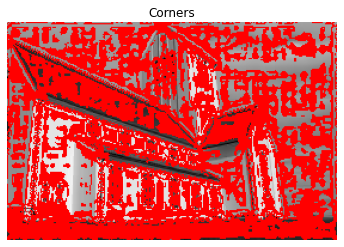

In [12]:
#Non maximum supression

#get original image
oimg = imread('image1.jfif')

#Get a copy of the original image for future use
imageCorners = np.copy(oimg)
imageEdges = np.copy(oimg)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            imageCorners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            imageEdges[rowindex, colindex] = [0,255,0]

plt.imshow(imageCorners)
plt.title("Corners")
plt.axis('off')

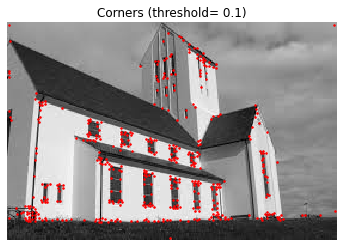

In [13]:
#Finding local maxima of peaks
threshold = 0.1
cornerMax = corner_peaks(harris_response,threshold_rel=threshold)

#Printing image to show edges
plt.imshow(oimg, interpolation='nearest', cmap=plt.cm.gray)
plt.title('Corners (threshold= ' + str(threshold) + ')')
plt.axis('off')
plt.plot(cornerMax[:, 1], cornerMax[:, 0], '.r', markersize=3)